---
Goal: Pesudo-bulk Analysis on raw data 

Perv: 02_Hill_AF_QC_comparison_preprocessing.ipynb (Clustering and Cell Typing)

Next: NA

---

---
# 1- Import data & setups

In [1]:
# ====================================================================
# Import data
# ====================================================================

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set parameters
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)

print("="*60)
print("Pseudo-bulk Differential Gene Expression Analysis")
print("Hill AF Study: Case vs Control")
print("="*60)

# ====================================================================
# Load Data
# ====================================================================

print("\n" + "="*60)
print("Loading Data")
print("="*60)

data_path = "/work/archive/farhadie/public_studies/Hill/QC_comparison_analysis/processed_data/Hill_preprocessed_with_celltypes_20251018.h5ad"

adata = sc.read_h5ad(data_path)

print(f"\n✓ Data loaded:")
print(f"  Cells: {adata.n_obs:,}")
print(f"  Genes: {adata.n_vars:,}")

# Check metadata
print(f"\nMetadata columns:")
print(f"  AF status: {adata.obs['af_status'].value_counts().to_dict()}")
print(f"  Cell types: {adata.obs['cell_type_assigned'].nunique()}")
print(f"  Samples: {adata.obs['sample_id'].nunique()}")

# ====================================================================
# Setup Output Directories
# ====================================================================

output_base = Path("/work/archive/farhadie/public_studies/Hill/QC_comparison_analysis")
results_dir = output_base / "pseudobulk_DGE"
figures_dir = results_dir / "figures"

results_dir.mkdir(exist_ok=True)
figures_dir.mkdir(exist_ok=True)

print(f"\n✓ Output directories created:")
print(f"  {results_dir}")

# ====================================================================
# Summary of Data Structure
# ====================================================================

print("\n" + "="*60)
print("Data Structure Summary")
print("="*60)

# Cells per cell type
print("\nCells per cell type:")
celltype_counts = adata.obs['cell_type_assigned'].value_counts()
for ct, count in celltype_counts.items():
    print(f"  {ct:15s}: {count:>6,} cells")

# Samples per condition
print("\nSamples per condition:")
sample_condition = adata.obs[['sample_id', 'af_status']].drop_duplicates()
condition_counts = sample_condition['af_status'].value_counts()
for cond, count in condition_counts.items():
    print(f"  {cond:10s}: {count:>2} samples")

# Cells per condition per cell type
print("\nCells per condition per cell type:")
ct_condition = adata.obs.groupby(['cell_type_assigned', 'af_status']).size().unstack(fill_value=0)
print(ct_condition)

print("\n" + "="*60)
print("Ready for Pseudo-bulk Analysis")
print("="*60)
print("\nNext steps:")
print("  1. Aggregate counts to pseudo-bulk per sample")
print("  2. Perform DE analysis for each cell type")
print("  3. Visualize results (volcano plots, heatmaps)")

/opt/micromamba/envs/shortcake_default/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


Pseudo-bulk Differential Gene Expression Analysis
Hill AF Study: Case vs Control

Loading Data

✓ Data loaded:
  Cells: 262,003
  Genes: 35,638

Metadata columns:
  AF status: {'case': 139856, 'control': 122147}
  Cell types: 12
  Samples: 34

✓ Output directories created:
  /work/archive/farhadie/public_studies/Hill/QC_comparison_analysis/pseudobulk_DGE

Data Structure Summary

Cells per cell type:
  FB             : 69,912 cells
  CM_nucl        : 53,788 cells
  MP             : 32,598 cells
  VEC            : 30,119 cells
  AD             : 18,325 cells
  PER            : 14,546 cells
  SMC            : 13,567 cells
  N              : 10,466 cells
  L              :  6,545 cells
  EEC            :  5,754 cells
  MESO           :  3,400 cells
  SC             :  2,983 cells

Samples per condition:
  case      : 18 samples
  control   : 16 samples

Cells per condition per cell type:
af_status            case  control
cell_type_assigned                
AD                   8556     976

---
# 2- Aggregate counts to pseudo-bulk per sample

In [2]:
# ====================================================================
# Step 1: Aggregate Counts to Pseudo-bulk per Sample
# ====================================================================

print("="*60)
print("Step 1: Pseudo-bulk Aggregation")
print("="*60)

# ====================================================================
# Check if counts layer exists
# ====================================================================

print("\nChecking data layers:")
print(f"  Available layers: {list(adata.layers.keys())}")
print(f"  Using layer: 'counts'")

if 'counts' not in adata.layers:
    print("  ⚠️  Warning: 'counts' layer not found, using .X")
    # If counts not available, use X
    adata.layers['counts'] = adata.X.copy()

# ====================================================================
# Create pseudo-bulk samples
# ====================================================================

print("\n" + "="*60)
print("Aggregating Counts to Pseudo-bulk")
print("="*60)

# Create a unique identifier for each pseudo-bulk sample: sample_id + cell_type
adata.obs['pseudobulk_id'] = (
    adata.obs['sample_id'].astype(str) + '_' + 
    adata.obs['cell_type_assigned'].astype(str)
)

print(f"\nTotal pseudo-bulk samples: {adata.obs['pseudobulk_id'].nunique()}")

# Get metadata for each pseudo-bulk sample
pseudobulk_metadata = adata.obs.groupby('pseudobulk_id').agg({
    'sample_id': 'first',
    'cell_type_assigned': 'first',
    'af_status': 'first',
    'sex': 'first',
    'donor_id': 'first'
}).reset_index()

print(f"\nPseudo-bulk metadata shape: {pseudobulk_metadata.shape}")
print(pseudobulk_metadata.head())

# ====================================================================
# Aggregate counts for each pseudo-bulk sample
# ====================================================================

print("\n" + "="*60)
print("Summing Counts per Pseudo-bulk Sample")
print("="*60)

from scipy.sparse import csr_matrix
import gc

# Get counts matrix
counts_matrix = adata.layers['counts']

# Create pseudo-bulk count matrix
pseudobulk_ids = adata.obs['pseudobulk_id'].values
unique_pb_ids = adata.obs['pseudobulk_id'].unique()

print(f"Aggregating {len(unique_pb_ids)} pseudo-bulk samples...")

# Initialize matrix
pseudobulk_counts = np.zeros((len(unique_pb_ids), adata.n_vars))

for i, pb_id in enumerate(unique_pb_ids):
    if i % 50 == 0:
        print(f"  Processing {i}/{len(unique_pb_ids)}...")
    
    # Get cells for this pseudo-bulk sample
    mask = pseudobulk_ids == pb_id
    
    # Sum counts
    if isinstance(counts_matrix, csr_matrix):
        pseudobulk_counts[i, :] = counts_matrix[mask, :].sum(axis=0).A1
    else:
        pseudobulk_counts[i, :] = counts_matrix[mask, :].sum(axis=0)

print(f"✓ Aggregation complete")

# ====================================================================
# Create pseudo-bulk AnnData object
# ====================================================================

print("\n" + "="*60)
print("Creating Pseudo-bulk AnnData Object")
print("="*60)

# Create new AnnData with pseudo-bulk data
adata_pb = sc.AnnData(
    X=pseudobulk_counts,
    obs=pseudobulk_metadata.set_index('pseudobulk_id'),
    var=adata.var.copy()
)

print(f"\nPseudo-bulk AnnData:")
print(f"  Samples: {adata_pb.n_obs}")
print(f"  Genes: {adata_pb.n_vars}")

# ====================================================================
# Filter pseudo-bulk samples
# ====================================================================

print("\n" + "="*60)
print("Filtering Pseudo-bulk Data")
print("="*60)

# Filter genes: keep genes expressed in at least 3 pseudo-bulk samples
min_samples = 3
gene_counts = (adata_pb.X > 0).sum(axis=0)
if isinstance(gene_counts, np.matrix):
    gene_counts = np.asarray(gene_counts).flatten()

genes_keep = gene_counts >= min_samples
print(f"  Genes before filtering: {adata_pb.n_vars}")
print(f"  Genes with ≥{min_samples} samples: {genes_keep.sum()}")

adata_pb = adata_pb[:, genes_keep].copy()

print(f"  Genes after filtering: {adata_pb.n_vars}")

# ====================================================================
# Summary by cell type
# ====================================================================

print("\n" + "="*60)
print("Pseudo-bulk Summary by Cell Type")
print("="*60)

for celltype in adata_pb.obs['cell_type_assigned'].unique():
    ct_data = adata_pb[adata_pb.obs['cell_type_assigned'] == celltype]
    
    n_case = (ct_data.obs['af_status'] == 'case').sum()
    n_control = (ct_data.obs['af_status'] == 'control').sum()
    
    print(f"\n{celltype}:")
    print(f"  Case samples: {n_case}")
    print(f"  Control samples: {n_control}")
    print(f"  Total: {ct_data.n_obs}")
    
    if n_case < 3 or n_control < 3:
        print(f"  ⚠️  Warning: Too few samples for robust DE analysis")

# ====================================================================
# Save pseudo-bulk data
# ====================================================================

print("\n" + "="*60)
print("Saving Pseudo-bulk Data")
print("="*60)

pb_file = results_dir / f"pseudobulk_aggregated_{datetime.now().strftime('%Y%m%d')}.h5ad"
adata_pb.write_h5ad(pb_file)

print(f"✓ Pseudo-bulk data saved: {pb_file}")

# Also save metadata
metadata_file = results_dir / "pseudobulk_metadata.csv"
adata_pb.obs.to_csv(metadata_file)

print(f"✓ Metadata saved: {metadata_file}")

# ====================================================================
# Quality Control Plots
# ====================================================================

print("\n" + "="*60)
print("Creating QC Plots")
print("="*60)

# Plot 1: Library sizes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Library size per sample
library_sizes = adata_pb.X.sum(axis=1)
if isinstance(library_sizes, np.matrix):
    library_sizes = np.asarray(library_sizes).flatten()

adata_pb.obs['library_size'] = library_sizes

# By condition
sns.boxplot(data=adata_pb.obs, x='af_status', y='library_size', ax=axes[0])
axes[0].set_ylabel('Total Counts', fontsize=12)
axes[0].set_xlabel('Condition', fontsize=12)
axes[0].set_title('Library Size by Condition', fontsize=14, fontweight='bold')
axes[0].set_yscale('log')

# By cell type
sns.boxplot(data=adata_pb.obs, x='cell_type_assigned', y='library_size', 
            hue='af_status', ax=axes[1])
axes[1].set_ylabel('Total Counts', fontsize=12)
axes[1].set_xlabel('Cell Type', fontsize=12)
axes[1].set_title('Library Size by Cell Type and Condition', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(figures_dir / 'pseudobulk_library_sizes.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_dir / 'pseudobulk_library_sizes.pdf', bbox_inches='tight')
plt.close()

print(f"✓ Library size plot saved")

# Plot 2: Number of genes detected
n_genes = (adata_pb.X > 0).sum(axis=1)
if isinstance(n_genes, np.matrix):
    n_genes = np.asarray(n_genes).flatten()

adata_pb.obs['n_genes'] = n_genes

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=adata_pb.obs, x='af_status', y='n_genes', ax=axes[0])
axes[0].set_ylabel('Number of Genes Detected', fontsize=12)
axes[0].set_xlabel('Condition', fontsize=12)
axes[0].set_title('Genes Detected by Condition', fontsize=14, fontweight='bold')

sns.boxplot(data=adata_pb.obs, x='cell_type_assigned', y='n_genes', 
            hue='af_status', ax=axes[1])
axes[1].set_ylabel('Number of Genes Detected', fontsize=12)
axes[1].set_xlabel('Cell Type', fontsize=12)
axes[1].set_title('Genes Detected by Cell Type', fontsize=14, fontweight='bold')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(figures_dir / 'pseudobulk_genes_detected.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_dir / 'pseudobulk_genes_detected.pdf', bbox_inches='tight')
plt.close()

print(f"✓ Genes detected plot saved")

# ====================================================================
# Summary
# ====================================================================

print("\n" + "="*60)
print("Pseudo-bulk Aggregation Complete!")
print("="*60)

print(f"\nSummary:")
print(f"  Original cells: {adata.n_obs:,}")
print(f"  Pseudo-bulk samples: {adata_pb.n_obs}")
print(f"  Genes after filtering: {adata_pb.n_vars:,}")
print(f"  Cell types: {adata_pb.obs['cell_type_assigned'].nunique()}")

print(f"\nFiles saved:")
print(f"  - {pb_file.name}")
print(f"  - pseudobulk_metadata.csv")
print(f"  - QC plots (PNG + PDF)")

print(f"\n{'='*60}")
print("Ready for DESeq2 Analysis!")
print(f"{'='*60}")

Step 1: Pseudo-bulk Aggregation

Checking data layers:
  Available layers: ['counts']
  Using layer: 'counts'

Aggregating Counts to Pseudo-bulk

Total pseudo-bulk samples: 408

Pseudo-bulk metadata shape: (408, 6)
     pseudobulk_id sample_id cell_type_assigned af_status sex  donor_id
0       1279_3n_AD   1279_3n                 AD      case   f  P1279_3n
1  1279_3n_CM_nucl   1279_3n            CM_nucl      case   f  P1279_3n
2      1279_3n_EEC   1279_3n                EEC      case   f  P1279_3n
3       1279_3n_FB   1279_3n                 FB      case   f  P1279_3n
4        1279_3n_L   1279_3n                  L      case   f  P1279_3n

Summing Counts per Pseudo-bulk Sample
Aggregating 408 pseudo-bulk samples...
  Processing 0/408...
  Processing 50/408...
  Processing 100/408...
  Processing 150/408...
  Processing 200/408...
  Processing 250/408...
  Processing 300/408...
  Processing 350/408...
  Processing 400/408...
✓ Aggregation complete

Creating Pseudo-bulk AnnData Object

P

---
# 3- Perform DESeq2 analysis for each cell type

In [39]:
# ====================================================================
# Step 2: DESeq2 Analysis - FIXED for contrast
# ====================================================================

print("="*60)
print("Step 2: DESeq2 Analysis per Cell Type")
print("="*60)

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# Store results
deseq2_results = {}
deseq2_stats_summary = []

# ====================================================================
# Run DESeq2 for each cell type
# ====================================================================

print("\n" + "="*60)
print("Running DESeq2 Analysis")
print("="*60)

cell_types = adata_pb.obs['cell_type_assigned'].unique()

for i, celltype in enumerate(cell_types, 1):
    print(f"\n{'='*60}")
    print(f"[{i}/{len(cell_types)}] Analyzing: {celltype}")
    print(f"{'='*60}")
    
    # Subset to this cell type
    ct_mask = adata_pb.obs['cell_type_assigned'] == celltype
    adata_ct = adata_pb[ct_mask].copy()
    
    # Check sample sizes
    n_case = (adata_ct.obs['af_status'] == 'case').sum()
    n_control = (adata_ct.obs['af_status'] == 'control').sum()
    
    print(f"  Case samples: {n_case}")
    print(f"  Control samples: {n_control}")
    
    # Skip if too few samples
    if n_case < 3 or n_control < 3:
        print(f"  ⚠️  Skipping: Need at least 3 samples per group")
        continue
    
    # Filter genes
    min_samples_ct = max(3, int(0.1 * adata_ct.n_obs))
    gene_counts_ct = (adata_ct.X > 0).sum(axis=0)
    if isinstance(gene_counts_ct, np.matrix):
        gene_counts_ct = np.asarray(gene_counts_ct).flatten()
    
    genes_keep_ct = gene_counts_ct >= min_samples_ct
    print(f"  Genes before filtering: {adata_ct.n_vars}")
    print(f"  Genes after filtering: {genes_keep_ct.sum()}")
    
    if genes_keep_ct.sum() < 100:
        print(f"  ⚠️  Skipping: Too few genes")
        continue
    
    adata_ct = adata_ct[:, genes_keep_ct].copy()
    
    # Prepare count matrix (samples as rows, genes as columns)
    counts_df = pd.DataFrame(
        adata_ct.X,
        index=adata_ct.obs_names,
        columns=adata_ct.var_names
    )
    
    # Prepare metadata with proper categorical
    metadata_df = adata_ct.obs[['af_status']].copy()
    metadata_df['af_status'] = pd.Categorical(
        metadata_df['af_status'],
        categories=['control', 'case']  # control as reference
    )
    
    print(f"  Count matrix: {counts_df.shape} (samples × genes)")
    print(f"  Metadata: {metadata_df.shape}")
    
    try:
        # Run DESeq2
        print(f"  Running DESeq2...")
        
        # Create DESeq2 dataset with ref_level
        dds = DeseqDataSet(
            counts=counts_df,
            metadata=metadata_df,
            design_factors='af_status',
            ref_level=['af_status', 'control'],  # Set control as reference
            refit_cooks=True,
            n_cpus=4
        )
        
        # Fit DESeq2
        dds.deseq2()
        
        print(f"  ✓ DESeq2 fit completed")
        
        # Get statistics with contrast
        stat_res = DeseqStats(
            dds,
            contrast=['af_status', 'case', 'control'],  # case vs control
            n_cpus=4
        )
        
        stat_res.summary()
        
        print(f"  ✓ Statistics computed")
        
        # Get results
        results_df = stat_res.results_df.copy()
        results_df['cell_type'] = celltype
        results_df['gene'] = results_df.index
        
        # Add additional columns
        results_df['significant'] = (results_df['padj'] < 0.05) & (np.abs(results_df['log2FoldChange']) > 0.5)
        results_df['direction'] = np.where(
            results_df['log2FoldChange'] > 0,
            'Up in Case',
            'Down in Case'
        )
        
        # Store results
        deseq2_results[celltype] = results_df
        
        # Summary statistics
        n_sig = results_df['significant'].sum()
        n_up = ((results_df['padj'] < 0.05) & (results_df['log2FoldChange'] > 0.5)).sum()
        n_down = ((results_df['padj'] < 0.05) & (results_df['log2FoldChange'] < -0.5)).sum()
        
        print(f"\n  Results:")
        print(f"    Genes tested: {len(results_df):,}")
        print(f"    Significant DEGs: {n_sig:,}")
        print(f"      ↑ Up in Case: {n_up:,}")
        print(f"      ↓ Down in Case: {n_down:,}")
        
        # Add to summary
        deseq2_stats_summary.append({
            'cell_type': celltype,
            'n_case': n_case,
            'n_control': n_control,
            'n_genes_tested': len(results_df),
            'n_significant': n_sig,
            'n_up': n_up,
            'n_down': n_down
        })
        
    except Exception as e:
        print(f"  ❌ Error: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*60}")
print(f"Completed: {len(deseq2_results)} cell types analyzed")
print(f"{'='*60}")

# ====================================================================
# Save results
# ====================================================================

print("\n" + "="*60)
print("Saving Results")
print("="*60)

# Save individual results
for celltype, results_df in deseq2_results.items():
    output_file = results_dir / f"DESeq2_{celltype}_case_vs_control.csv"
    results_df.to_csv(output_file, index=False)
    print(f"  ✓ {celltype}")

# Save combined results
if len(deseq2_results) > 0:
    all_results = pd.concat(deseq2_results.values(), ignore_index=True)
    combined_file = results_dir / "DESeq2_all_celltypes_combined.csv"
    all_results.to_csv(combined_file, index=False)
    print(f"\n✓ Combined: {combined_file.name}")

# Save summary
if len(deseq2_stats_summary) > 0:
    summary_df = pd.DataFrame(deseq2_stats_summary)
    summary_file = results_dir / "DESeq2_summary.csv"
    summary_df.to_csv(summary_file, index=False)
    
    print(f"\n{'='*60}")
    print("Summary")
    print(f"{'='*60}")
    print(summary_df.to_string(index=False))
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    summary_df_sorted = summary_df.sort_values('n_significant', ascending=True)
    y_pos = np.arange(len(summary_df_sorted))
    
    ax.barh(y_pos, summary_df_sorted['n_up'], label='Up in Case', color='#E74C3C', alpha=0.7)
    ax.barh(y_pos, -summary_df_sorted['n_down'], label='Down in Case', color='#3498DB', alpha=0.7)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(summary_df_sorted['cell_type'])
    ax.set_xlabel('Number of DEGs', fontsize=12, fontweight='bold')
    ax.set_title('DESeq2: Case vs Control', fontsize=14, fontweight='bold')
    ax.axvline(x=0, color='black', linewidth=0.8)
    ax.legend()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(figures_dir / 'DESeq2_summary.png', dpi=300, bbox_inches='tight')
    plt.savefig(figures_dir / 'DESeq2_summary.pdf', bbox_inches='tight')
    plt.close()
    
    print(f"\n✓ Plot saved")

print(f"\n{'='*60}")
print("Complete!")
print(f"{'='*60}")

Step 2: DESeq2 Analysis per Cell Type

Running DESeq2 Analysis

[1/12] Analyzing: AD
  Case samples: 18
  Control samples: 16
  Genes before filtering: 35619
  Genes after filtering: 32954
  Count matrix: (34, 32954) (samples × genes)
  Metadata: (34, 1)
  Running DESeq2...
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 6.15 seconds.

Fitting dispersion trend curve...
... done in 0.50 seconds.

Fitting MAP dispersions...
... done in 7.18 seconds.

Fitting LFCs...
... done in 5.49 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 1109 outlier genes.

Fitting dispersions...
... done in 0.34 seconds.

Fitting MAP dispersions...
... done in 0.29 seconds.

Fitting LFCs...
... done in 0.20 seconds.

Running Wald tests...


  ✓ DESeq2 fit completed


... done in 1.87 seconds.



Log2 fold change & Wald test p-value: af_status case vs control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009   1.831282       -0.222363  0.427811 -0.519769  0.603224   
ENSG00000239945   0.181487       -0.127677  1.281701 -0.099616  0.920650   
ENSG00000241860   7.966446        0.253415  0.316656  0.800285  0.423545   
ENSG00000241599   0.202858       -1.059673  1.670941 -0.634177  0.525965   
ENSG00000286448   0.142232        0.391969  2.269010  0.172749  0.862849   
...                    ...             ...       ...       ...       ...   
ENSG00000271254  16.916032       -0.452344  0.283994 -1.592797  0.111206   
ENSG00000276345   0.846613        0.025617  0.810165  0.031620  0.974775   
ENSG00000273554   0.154146        0.424417  2.062123  0.205816  0.836935   
ENSG00000278817   2.003177        0.005131  0.529221  0.009695  0.992265   
ENSG00000277196   2.592420        1.465577  0.704803  2.079414  0.037579   

                     pa

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 5.54 seconds.

Fitting dispersion trend curve...
... done in 0.42 seconds.

Fitting MAP dispersions...
... done in 7.51 seconds.

Fitting LFCs...
... done in 6.08 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 1059 outlier genes.

Fitting dispersions...
... done in 0.33 seconds.

Fitting MAP dispersions...
... done in 0.26 seconds.

Fitting LFCs...
... done in 0.20 seconds.

Running Wald tests...


  ✓ DESeq2 fit completed


... done in 1.61 seconds.



Log2 fold change & Wald test p-value: af_status case vs control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009   0.691204        0.525596  0.549142  0.957122  0.338506   
ENSG00000239945   0.133516       -0.436101  1.072038 -0.406796  0.684158   
ENSG00000241860   3.092449       -0.004197  0.349441 -0.012010  0.990418   
ENSG00000241599   0.055538       -0.128388  1.524854 -0.084197  0.932900   
ENSG00000286448   0.026532        0.005152  2.153408  0.002393  0.998091   
...                    ...             ...       ...       ...       ...   
ENSG00000271254  10.145413       -0.610571  0.347754 -1.755753  0.079131   
ENSG00000276345   0.336324       -0.238601  1.152543 -0.207021  0.835993   
ENSG00000273554   0.057387       -0.387579  1.695741 -0.228560  0.819211   
ENSG00000278817   0.776895       -0.042032  0.524129 -0.080194  0.936083   
ENSG00000277196   0.945733       -0.808809  0.664892 -1.216451  0.223813   

                     pa

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 5.56 seconds.

Fitting dispersion trend curve...
... done in 0.47 seconds.

Fitting MAP dispersions...
... done in 7.18 seconds.

Fitting LFCs...
... done in 5.94 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 1021 outlier genes.

Fitting dispersions...
... done in 0.26 seconds.

Fitting MAP dispersions...
... done in 0.27 seconds.

Fitting LFCs...
... done in 0.19 seconds.



  ✓ DESeq2 fit completed


Running Wald tests...
... done in 1.48 seconds.



Log2 fold change & Wald test p-value: af_status case vs control
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009  1.439562        0.310180  0.456903  0.678875  0.497217   
ENSG00000239945  0.100780        0.029069  2.385850  0.012184  0.990279   
ENSG00000241860  6.515555       -0.153122  0.357066 -0.428833  0.668045   
ENSG00000241599  0.131300        1.563003  1.994021  0.783845  0.433131   
ENSG00000286448  0.205807        0.560673  2.627570  0.213381  0.831030   
...                   ...             ...       ...       ...       ...   
ENSG00000276345  0.302951       -0.175326  0.885730 -0.197945  0.843088   
ENSG00000278633  0.036935        1.027367  3.146463  0.326515  0.744035   
ENSG00000276017  0.075226        0.748433  2.453813  0.305008  0.760360   
ENSG00000278817  1.574157        0.532393  0.490798  1.084752  0.278032   
ENSG00000277196  1.390153        0.597545  0.679856  0.878929  0.379440   

                    padj  
ENSG0000

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 5.29 seconds.

Fitting dispersion trend curve...
... done in 0.40 seconds.

Fitting MAP dispersions...
... done in 7.13 seconds.

Fitting LFCs...
... done in 6.33 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 978 outlier genes.

Fitting dispersions...
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 0.24 seconds.

Fitting LFCs...
... done in 0.19 seconds.



  ✓ DESeq2 fit completed


Running Wald tests...
... done in 1.55 seconds.



Log2 fold change & Wald test p-value: af_status case vs control
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
ENSG00000238009  0.641464        0.115610  0.518140  0.223125  0.823438   NaN
ENSG00000239945  0.099988        0.190402  1.316482  0.144630  0.885003   NaN
ENSG00000241860  2.763449        0.313164  0.404778  0.773667  0.439128   NaN
ENSG00000241599  0.132768        0.379652  1.816825  0.208965  0.834476   NaN
ENSG00000286448  0.078444       -0.007541  2.121695 -0.003554  0.997164   NaN
...                   ...             ...       ...       ...       ...   ...
ENSG00000271254  7.740895       -0.045000  0.332468 -0.135353  0.892333   NaN
ENSG00000276345  0.411400        0.044770  1.023182  0.043755  0.965099   NaN
ENSG00000273554  0.018436        0.235799  2.232786  0.105608  0.915894   NaN
ENSG00000278817  0.529037        0.355094  0.740628  0.479450  0.631618   NaN
ENSG00000277196  0.476773        0.031843  0.730666  0.043581  0.965238   NaN


Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 5.98 seconds.

Fitting dispersion trend curve...
... done in 0.52 seconds.

Fitting MAP dispersions...
... done in 6.53 seconds.

Fitting LFCs...
... done in 5.09 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 1111 outlier genes.

Fitting dispersions...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 0.27 seconds.

Fitting LFCs...
... done in 0.20 seconds.

Running Wald tests...


  ✓ DESeq2 fit completed


... done in 1.87 seconds.



Log2 fold change & Wald test p-value: af_status case vs control
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009    0.743271       -1.253404  0.622599 -2.013182  0.044096   
ENSG00000239945    0.044976       -0.179454  2.631402 -0.068197  0.945629   
ENSG00000241860    4.111206        0.448499  0.393138  1.140818  0.253946   
ENSG00000241599    0.187963       -0.355070  1.333294 -0.266311  0.790000   
ENSG00000290385    3.702691        0.551370  0.396463  1.390723  0.164309   
...                     ...             ...       ...       ...       ...   
ENSG00000273748  100.193300        0.452088  0.272413  1.659570  0.097001   
ENSG00000271254    9.277434       -0.183434  0.347388 -0.528038  0.597473   
ENSG00000276345    0.393250       -0.837953  1.076641 -0.778303  0.436390   
ENSG00000278817    0.649135       -0.527735  0.658480 -0.801445  0.422874   
ENSG00000277196    0.597165        0.666693  0.939913  0.709314  0.478130   

           

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 5.61 seconds.

Fitting dispersion trend curve...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 6.64 seconds.

Fitting LFCs...
... done in 5.65 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 933 outlier genes.

Fitting dispersions...
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 0.22 seconds.

Fitting LFCs...
... done in 0.20 seconds.



  ✓ DESeq2 fit completed


Running Wald tests...
... done in 1.36 seconds.



Log2 fold change & Wald test p-value: af_status case vs control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009   0.733782       -0.340747  0.700443 -0.486473  0.626631   
ENSG00000239945   0.021116       -0.506980  3.155550 -0.160663  0.872359   
ENSG00000241860   3.923073        0.067544  0.554209  0.121875  0.902998   
ENSG00000241599   0.059328       -0.955421  2.533206 -0.377159  0.706056   
ENSG00000290385   3.375417       -0.661280  0.372904 -1.773328  0.076174   
...                    ...             ...       ...       ...       ...   
ENSG00000273748  87.856651        0.614562  0.268842  2.285959  0.022257   
ENSG00000271254   8.225841       -0.905723  0.317735 -2.850564  0.004364   
ENSG00000276345   0.251115       -1.207897  0.892917 -1.352754  0.176134   
ENSG00000278817   0.550029        0.077433  0.594704  0.130204  0.896405   
ENSG00000277196   0.443350        0.066688  0.833853  0.079976  0.936256   

                     pa

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 5.20 seconds.

Fitting dispersion trend curve...
... done in 0.58 seconds.

Fitting MAP dispersions...
... done in 6.32 seconds.

Fitting LFCs...
... done in 4.95 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 913 outlier genes.

Fitting dispersions...
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 0.22 seconds.

Fitting LFCs...
... done in 0.16 seconds.



  ✓ DESeq2 fit completed


Running Wald tests...
... done in 1.45 seconds.



Log2 fold change & Wald test p-value: af_status case vs control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009   0.620192       -0.047357  0.668818 -0.070806  0.943552   
ENSG00000239945   0.029053       -0.458321  3.130581 -0.146401  0.883605   
ENSG00000241860   2.670718        0.748897  0.531653  1.408620  0.158948   
ENSG00000290385   2.733826       -0.295494  0.420003 -0.703552  0.481712   
ENSG00000291215   6.707037        0.092980  0.277256  0.335357  0.737356   
...                    ...             ...       ...       ...       ...   
ENSG00000273748  72.904040        0.813028  0.290017  2.803379  0.005057   
ENSG00000271254   7.220000       -0.783183  0.298664 -2.622287  0.008734   
ENSG00000276345   0.250698        0.019321  1.532781  0.012605  0.989943   
ENSG00000278817   0.482729        0.087958  0.941868  0.093387  0.925596   
ENSG00000277196   0.784162       -0.378510  0.917099 -0.412725  0.679808   

                     pa

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 4.77 seconds.

Fitting dispersion trend curve...
... done in 0.41 seconds.

Fitting MAP dispersions...
... done in 5.88 seconds.

Fitting LFCs...
... done in 4.81 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 697 outlier genes.

Fitting dispersions...
... done in 0.18 seconds.

Fitting MAP dispersions...
... done in 0.18 seconds.

Fitting LFCs...
... done in 0.19 seconds.



  ✓ DESeq2 fit completed


Running Wald tests...
... done in 1.30 seconds.



Log2 fold change & Wald test p-value: af_status case vs control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009   0.213314       -1.093979  1.002531 -1.091218  0.275177   
ENSG00000241860   1.242984       -0.014485  0.551207 -0.026279  0.979035   
ENSG00000290385   1.066635       -0.681553  0.693223 -0.983165  0.325526   
ENSG00000291215   2.704357       -0.052812  0.457290 -0.115490  0.908057   
LINC01409        10.120349       -0.068495  0.247123 -0.277168  0.781651   
...                    ...             ...       ...       ...       ...   
ENSG00000273748  32.544031        0.774759  0.274774  2.819629  0.004808   
ENSG00000271254   2.934812       -0.660793  0.360396 -1.833522  0.066725   
ENSG00000276345   0.086951       -1.047577  2.913323 -0.359582  0.719160   
ENSG00000278817   0.165595       -0.521116  1.125923 -0.462835  0.643483   
ENSG00000277196   0.207164       -0.932474  1.518866 -0.613928  0.539263   

                     pa

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 4.47 seconds.

Fitting dispersion trend curve...
... done in 0.38 seconds.

Fitting MAP dispersions...
... done in 5.78 seconds.

Fitting LFCs...
... done in 4.47 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 535 outlier genes.

Fitting dispersions...
... done in 0.17 seconds.

Fitting MAP dispersions...
... done in 0.16 seconds.

Fitting LFCs...
... done in 0.14 seconds.

Running Wald tests...


  ✓ DESeq2 fit completed


... done in 1.30 seconds.



Log2 fold change & Wald test p-value: af_status case vs control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009   0.152482        0.088311  1.662340  0.053124  0.957633   
ENSG00000241860   0.484962       -0.473176  0.724092 -0.653475  0.513450   
ENSG00000290385   0.476879       -0.024499  0.731497 -0.033492  0.973282   
ENSG00000235146   0.063551        0.374181  2.947072  0.126967  0.898966   
ENSG00000291215   1.447893        0.092367  0.468553  0.197131  0.843725   
...                    ...             ...       ...       ...       ...   
ENSG00000273748  18.271054        0.572434  0.290379  1.971334  0.048686   
ENSG00000271254   1.820391        0.138238  0.500861  0.276001  0.782547   
ENSG00000276345   0.109143       -0.376210  2.035402 -0.184833  0.853360   
ENSG00000278817   0.169203        0.368441  1.656206  0.222461  0.823955   
ENSG00000277196   0.116445        0.126028  1.667781  0.075566  0.939764   

                     pa

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 4.49 seconds.

Fitting dispersion trend curve...
... done in 0.37 seconds.

Fitting MAP dispersions...
... done in 5.54 seconds.

Fitting LFCs...
... done in 4.80 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 624 outlier genes.

Fitting dispersions...
... done in 0.17 seconds.

Fitting MAP dispersions...
... done in 0.17 seconds.

Fitting LFCs...
... done in 0.14 seconds.

Running Wald tests...


  ✓ DESeq2 fit completed


... done in 1.19 seconds.



Log2 fold change & Wald test p-value: af_status case vs control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009   0.229476        0.127533  1.115680  0.114310  0.908992   
ENSG00000241860   0.772335        0.502812  0.678422  0.741150  0.458603   
ENSG00000290385   0.532419       -0.411373  0.648693 -0.634157  0.525979   
ENSG00000291215   1.377675       -0.247371  0.537255 -0.460434  0.645204   
LINC01409         7.854536       -0.022775  0.304739 -0.074735  0.940426   
...                    ...             ...       ...       ...       ...   
ENSG00000278384   1.930338       -0.333910  0.447375 -0.746376  0.455440   
ENSG00000273748  17.492092        0.472768  0.302423  1.563266  0.117990   
ENSG00000271254   1.553088       -0.113683  0.490225 -0.231899  0.816617   
ENSG00000278817   0.037441        0.473118  2.822467  0.167626  0.866878   
ENSG00000277196   0.173558        0.838419  1.690505  0.495958  0.619924   

                     pa

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 4.11 seconds.

Fitting dispersion trend curve...
... done in 0.39 seconds.

Fitting MAP dispersions...
... done in 5.10 seconds.

Fitting LFCs...
... done in 4.17 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 501 outlier genes.

Fitting dispersions...
... done in 0.12 seconds.

Fitting MAP dispersions...
... done in 0.11 seconds.

Fitting LFCs...
... done in 0.10 seconds.

Running Wald tests...


  ✓ DESeq2 fit completed


... done in 1.43 seconds.



Log2 fold change & Wald test p-value: af_status case vs control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009   0.095409       -0.036737  1.698923 -0.021623  0.982748   
ENSG00000241860   0.240340       -0.143008  0.866868 -0.164971  0.868966   
ENSG00000290385   0.285388       -0.156193  0.823470 -0.189677  0.849562   
ENSG00000291215   0.980652        0.488761  0.566472  0.862816  0.388239   
LINC01409         3.047956        0.291893  0.379661  0.768825  0.441997   
...                    ...             ...       ...       ...       ...   
ENSG00000278384   1.279988        0.052820  0.533808  0.098949  0.921179   
ENSG00000273748  10.377730        0.710226  0.316346  2.245094  0.024762   
ENSG00000271254   1.320992       -0.228440  0.528974 -0.431856  0.665846   
ENSG00000278817   0.302177       -0.417959  1.328060 -0.314714  0.752979   
ENSG00000277196   0.079855        0.385771  2.069236  0.186432  0.852106   

                    pad

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 3.44 seconds.

Fitting dispersion trend curve...
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 4.57 seconds.

Fitting LFCs...
... done in 3.98 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 261 outlier genes.

Fitting dispersions...
... done in 0.07 seconds.

Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...
... done in 0.06 seconds.

Running Wald tests...


  ✓ DESeq2 fit completed


... done in 1.00 seconds.



Log2 fold change & Wald test p-value: af_status case vs control
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000241860  0.175877        0.453727  0.953790  0.475710  0.634281   
ENSG00000290385  0.696272       -0.574725  1.190037 -0.482947  0.629133   
ENSG00000291215  0.495084       -0.250566  0.661050 -0.379042  0.704657   
LINC01409        1.986760        0.264062  0.412821  0.639653  0.522398   
ENSG00000290784  0.248421       -0.751170  1.082586 -0.693866  0.487766   
...                   ...             ...       ...       ...       ...   
ENSG00000276256  0.389133       -0.923190  1.115688 -0.827463  0.407975   
ENSG00000278384  0.996182       -1.539588  0.661058 -2.328975  0.019860   
ENSG00000273748  5.479166        0.501523  0.382654  1.310645  0.189978   
ENSG00000271254  0.857574        0.171120  0.722333  0.236899  0.812735   
ENSG00000277196  0.069099       -0.068661  2.847700 -0.024111  0.980764   

                     padj  
ENSG000

---
# 4- Visualize DESeq2 Results

In [49]:
# ====================================================================
# Visualize DESeq2 Results
# ====================================================================

print("="*60)
print("Step 3: Creating Visualizations")
print("="*60)

# ====================================================================
# 1. Volcano Plots for Each Cell Type
# ====================================================================

print("\n" + "="*60)
print("Creating Volcano Plots")
print("="*60)

def create_volcano_plot(results_df, cell_type, output_dir, 
                        padj_threshold=0.05, lfc_threshold=0.5):
    """
    Create volcano plot for DE results
    """
    # Prepare data
    df = results_df.copy()
    df['-log10(padj)'] = -np.log10(df['padj'].replace(0, 1e-300))
    
    # Classify genes
    df['category'] = 'Not Significant'
    df.loc[(df['padj'] < padj_threshold) & (df['log2FoldChange'] > lfc_threshold), 'category'] = 'Up in Case'
    df.loc[(df['padj'] < padj_threshold) & (df['log2FoldChange'] < -lfc_threshold), 'category'] = 'Down in Case'
    
    # Count genes
    n_up = (df['category'] == 'Up in Case').sum()
    n_down = (df['category'] == 'Down in Case').sum()
    
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Plot points
    colors = {'Not Significant': '#CCCCCC', 'Up in Case': '#E74C3C', 'Down in Case': '#3498DB'}
    for category in ['Not Significant', 'Down in Case', 'Up in Case']:
        subset = df[df['category'] == category]
        ax.scatter(
            subset['log2FoldChange'],
            subset['-log10(padj)'],
            c=colors[category],
            alpha=0.6,
            s=20,
            label=category,
            edgecolors='none'
        )
    
    # Add threshold lines
    ax.axhline(-np.log10(padj_threshold), color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.axvline(lfc_threshold, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.axvline(-lfc_threshold, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    
    # Labels
    ax.set_xlabel('log₂ Fold Change (Case vs Control)', fontsize=12, fontweight='bold')
    ax.set_ylabel('-log₁₀(adjusted p-value)', fontsize=12, fontweight='bold')
    ax.set_title(f'Volcano Plot: {cell_type}\n{n_up} Up, {n_down} Down', 
                 fontsize=14, fontweight='bold')
    
    # Legend
    ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Annotate top genes
    sig_genes = df[(df['padj'] < padj_threshold) & (np.abs(df['log2FoldChange']) > lfc_threshold)]
    sig_genes = sig_genes.sort_values('padj').head(10)
    
    from adjustText import adjust_text
    texts = []
    for _, row in sig_genes.iterrows():
        texts.append(ax.text(row['log2FoldChange'], row['-log10(padj)'], 
                            row['gene'], fontsize=8, alpha=0.8))
    
    if len(texts) > 0:
        try:
            adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
        except:
            pass
    
    plt.tight_layout()
    
    return fig

# Create volcano plots
for celltype, results_df in deseq2_results.items():
    print(f"  Creating volcano plot for {celltype}...")
    
    try:
        fig = create_volcano_plot(results_df, celltype, figures_dir)
        
        png_file = figures_dir / f'volcano_{celltype}.png'
        pdf_file = figures_dir / f'volcano_{celltype}.pdf'
        
        fig.savefig(png_file, dpi=300, bbox_inches='tight')
        fig.savefig(pdf_file, bbox_inches='tight')
        plt.close(fig)
        
        print(f"    ✓ Saved: {png_file.name}")
        
    except Exception as e:
        print(f"    ❌ Error: {e}")

# ====================================================================
# 2. MA Plots
# ====================================================================

print("\n" + "="*60)
print("Creating MA Plots")
print("="*60)

def create_ma_plot(results_df, cell_type, output_dir, 
                   padj_threshold=0.05, lfc_threshold=0.5):
    """
    Create MA plot (log2FC vs mean expression)
    """
    df = results_df.copy()
    
    # Classify genes
    df['category'] = 'Not Significant'
    df.loc[(df['padj'] < padj_threshold) & (df['log2FoldChange'] > lfc_threshold), 'category'] = 'Up in Case'
    df.loc[(df['padj'] < padj_threshold) & (df['log2FoldChange'] < -lfc_threshold), 'category'] = 'Down in Case'
    
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    colors = {'Not Significant': '#CCCCCC', 'Up in Case': '#E74C3C', 'Down in Case': '#3498DB'}
    for category in ['Not Significant', 'Down in Case', 'Up in Case']:
        subset = df[df['category'] == category]
        ax.scatter(
            subset['baseMean'],
            subset['log2FoldChange'],
            c=colors[category],
            alpha=0.6,
            s=20,
            label=category,
            edgecolors='none'
        )
    
    # Add threshold lines
    ax.axhline(lfc_threshold, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.axhline(-lfc_threshold, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.axhline(0, color='black', linewidth=1)
    
    ax.set_xlabel('Mean Expression (baseMean)', fontsize=12, fontweight='bold')
    ax.set_ylabel('log₂ Fold Change', fontsize=12, fontweight='bold')
    ax.set_title(f'MA Plot: {cell_type}', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Create MA plots
for celltype, results_df in deseq2_results.items():
    print(f"  Creating MA plot for {celltype}...")
    
    try:
        fig = create_ma_plot(results_df, celltype, figures_dir)
        
        png_file = figures_dir / f'MA_plot_{celltype}.png'
        pdf_file = figures_dir / f'MA_plot_{celltype}.pdf'
        
        fig.savefig(png_file, dpi=300, bbox_inches='tight')
        fig.savefig(pdf_file, bbox_inches='tight')
        plt.close(fig)
        
        print(f"    ✓ Saved")
        
    except Exception as e:
        print(f"    ❌ Error: {e}")

# ====================================================================
# 3. Heatmap of Top DEGs per Cell Type - with Sex Annotation (FIXED)
# ====================================================================

# ====================================================================
# 3. Heatmap of Top DEGs - COMPLETELY FIXED
# ====================================================================

print("\n" + "="*60)
print("Creating Heatmap of Top DEGs")
print("="*60)

# Collect top DEGs from each cell type
top_genes_per_ct = {}
n_top = 20

for celltype, results_df in deseq2_results.items():
    sig_genes = results_df[
        (results_df['padj'] < 0.05) & 
        (np.abs(results_df['log2FoldChange']) > 0.5)
    ].sort_values('padj').head(n_top)
    
    top_genes_per_ct[celltype] = sig_genes['gene'].tolist()

# Get all top genes
all_top_genes = []
for genes in top_genes_per_ct.values():
    all_top_genes.extend(genes)
all_top_genes = list(set(all_top_genes))

print(f"  Total unique top genes: {len(all_top_genes)}")

if len(all_top_genes) > 0 and len(all_top_genes) < 500:
    
    # Get expression data from pseudobulk
    genes_in_data = [g for g in all_top_genes if g in adata_pb.var_names]
    
    if len(genes_in_data) > 0:
        print(f"  Genes found in data: {len(genes_in_data)}")
        
        # Extract expression matrix
        expr_data = adata_pb[:, genes_in_data].X
        if isinstance(expr_data, np.matrix):
            expr_data = np.asarray(expr_data)
        
        # Create dataframe
        expr_df = pd.DataFrame(
            expr_data,
            index=adata_pb.obs_names,
            columns=genes_in_data
        )
        
        # Transpose
        expr_matrix = expr_df.T
        
        # Log transform
        expr_matrix = np.log1p(expr_matrix)
        
        # Z-score per gene
        expr_matrix_z = expr_matrix.apply(
            lambda row: (row - row.mean()) / row.std() if row.std() > 0 else row,
            axis=1
        )
        
        # Remove NaN
        expr_matrix_z = expr_matrix_z.dropna(how='all')
        
        print(f"  Expression matrix shape: {expr_matrix_z.shape}")
        
        # Prepare color annotations - FIXED: Create DataFrame properly
        condition_colors = {'case': '#E74C3C', 'control': '#3498DB'}
        sex_colors = {'m': '#87CEEB', 'f': '#FFB6C1'}
        
        # Create DataFrame for col_colors
        col_colors_df = pd.DataFrame({
            'Condition': [condition_colors[x] for x in adata_pb.obs['af_status'].values],
            'Sex': [sex_colors[x] for x in adata_pb.obs['sex'].values]
        }, index=adata_pb.obs_names)
        
        print(f"  Creating clustermap...")
        
        try:
            g = sns.clustermap(
                expr_matrix_z,
                cmap='RdBu_r',
                center=0,
                vmin=-2,
                vmax=2,
                col_colors=col_colors_df,
                figsize=(18, max(12, len(expr_matrix_z) * 0.15)),
                cbar_kws={'label': 'Z-score', 'shrink': 0.5},
                dendrogram_ratio=(0.1, 0.05),
                colors_ratio=0.03,
                linewidths=0,
                rasterized=True,
                xticklabels=False,
                yticklabels=True if len(expr_matrix_z) < 100 else False
            )
            
            g.ax_heatmap.set_xlabel('Samples', fontsize=12, fontweight='bold')
            g.ax_heatmap.set_ylabel('Genes', fontsize=12, fontweight='bold')
            
            plt.suptitle(f'Top {n_top} DEGs per Cell Type (Total: {len(expr_matrix_z)} genes)', 
                         fontsize=14, fontweight='bold', y=0.98)
            
            # Add legend
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='#E74C3C', label='Case'),
                Patch(facecolor='#3498DB', label='Control'),
                Patch(facecolor='white', label=''),
                Patch(facecolor='#87CEEB', label='Male'),
                Patch(facecolor='#FFB6C1', label='Female')
            ]
            g.ax_heatmap.legend(handles=legend_elements, loc='upper left', 
                               bbox_to_anchor=(1.05, 1), frameon=True, 
                               title='Annotations', fontsize=9)
            
            png_file = figures_dir / 'heatmap_top_DEGs_all_celltypes.png'
            pdf_file = figures_dir / 'heatmap_top_DEGs_all_celltypes.pdf'
            
            plt.savefig(png_file, dpi=300, bbox_inches='tight')
            plt.savefig(pdf_file, bbox_inches='tight')
            plt.close()
            
            print(f"  ✓ Heatmap saved: {png_file.name}")
            
        except Exception as e:
            print(f"  ❌ Error: {e}")
            import traceback
            traceback.print_exc()

# ====================================================================
# 4. Individual Heatmaps per Cell Type - FIXED
# ====================================================================

print("\n" + "="*60)
print("Creating Individual Heatmaps per Cell Type")
print("="*60)

for celltype, results_df in deseq2_results.items():
    
    sig_genes = results_df[
        (results_df['padj'] < 0.05) & 
        (np.abs(results_df['log2FoldChange']) > 0.5)
    ].sort_values('padj').head(30)
    
    if len(sig_genes) < 5:
        print(f"  {celltype}: Too few DEGs ({len(sig_genes)}), skipping")
        continue
    
    genes = sig_genes['gene'].tolist()
    genes_in_data = [g for g in genes if g in adata_pb.var_names]
    
    if len(genes_in_data) < 5:
        continue
    
    print(f"  Creating heatmap for {celltype} ({len(genes_in_data)} genes)...")
    
    ct_mask = adata_pb.obs['cell_type_assigned'] == celltype
    adata_ct = adata_pb[ct_mask, genes_in_data]
    
    expr_data = adata_ct.X
    if isinstance(expr_data, np.matrix):
        expr_data = np.asarray(expr_data)
    
    expr_matrix = pd.DataFrame(
        expr_data,
        index=adata_ct.obs_names,
        columns=genes_in_data
    ).T
    
    expr_matrix = np.log1p(expr_matrix)
    
    expr_matrix_z = expr_matrix.apply(
        lambda row: (row - row.mean()) / row.std() if row.std() > 0 else row,
        axis=1
    )
    
    expr_matrix_z = expr_matrix_z.dropna(how='all')
    
    if expr_matrix_z.shape[0] < 3:
        print(f"    Too few genes after filtering, skipping")
        continue
    
    # Color annotations - FIXED
    condition_colors = {'case': '#E74C3C', 'control': '#3498DB'}
    sex_colors = {'m': '#87CEEB', 'f': '#FFB6C1'}
    
    col_colors_df = pd.DataFrame({
        'Condition': [condition_colors[x] for x in adata_ct.obs['af_status'].values],
        'Sex': [sex_colors[x] for x in adata_ct.obs['sex'].values]
    }, index=adata_ct.obs_names)
    
    try:
        g = sns.clustermap(
            expr_matrix_z,
            cmap='RdBu_r',
            center=0,
            vmin=-2,
            vmax=2,
            col_colors=col_colors_df,
            figsize=(max(10, len(expr_matrix_z.columns) * 0.3), 
                     max(8, len(expr_matrix_z) * 0.25)),
            cbar_kws={'label': 'Z-score', 'shrink': 0.7},
            xticklabels=False,
            yticklabels=True,
            linewidths=0,
            rasterized=True
        )
        
        g.ax_heatmap.set_xlabel('Samples', fontsize=10, fontweight='bold')
        g.ax_heatmap.set_ylabel('Genes', fontsize=10, fontweight='bold')
        
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#E74C3C', label='Case'),
            Patch(facecolor='#3498DB', label='Control'),
            Patch(facecolor='white', label=''),
            Patch(facecolor='#87CEEB', label='Male'),
            Patch(facecolor='#FFB6C1', label='Female')
        ]
        g.ax_heatmap.legend(handles=legend_elements, loc='upper left', 
                           bbox_to_anchor=(1.02, 1), frameon=True, fontsize=8,
                           title='Annotations')
        
        plt.suptitle(f'{celltype}: Top 30 DEGs', fontsize=12, fontweight='bold', y=0.98)
        
        png_file = figures_dir / f'heatmap_{celltype}_top30.png'
        pdf_file = figures_dir / f'heatmap_{celltype}_top30.pdf'
        
        plt.savefig(png_file, dpi=300, bbox_inches='tight')
        plt.savefig(pdf_file, bbox_inches='tight')
        plt.close()
        
        print(f"    ✓ Saved")
        
    except Exception as e:
        print(f"    ❌ Error: {e}")

print(f"\n{'='*60}")
print("Heatmap Visualization Complete!")
print(f"{'='*60}")
# ====================================================================
# 5. Shared DEGs Analysis
# ====================================================================

print("\n" + "="*60)
print("Analyzing Shared DEGs")
print("="*60)

# Get significant genes per cell type
sig_genes_per_ct = {}

for celltype, results_df in deseq2_results.items():
    sig_genes = results_df[
        (results_df['padj'] < 0.05) & 
        (np.abs(results_df['log2FoldChange']) > 0.5)
    ]['gene'].tolist()
    
    sig_genes_per_ct[celltype] = set(sig_genes)
    print(f"  {celltype}: {len(sig_genes)} DEGs")

# Create UpSet plot for overlaps
if len(sig_genes_per_ct) > 1:
    from upsetplot import from_contents, UpSet
    
    try:
        upset_data = from_contents(sig_genes_per_ct)
        
        fig = plt.figure(figsize=(14, 8))
        upset = UpSet(upset_data, show_counts=True, sort_by='cardinality')
        upset.plot(fig=fig)
        plt.suptitle('Overlap of DEGs across Cell Types', fontsize=14, fontweight='bold', y=0.98)
        
        png_file = figures_dir / 'upset_DEGs_overlap.png'
        pdf_file = figures_dir / 'upset_DEGs_overlap.pdf'
        
        plt.savefig(png_file, dpi=300, bbox_inches='tight')
        plt.savefig(pdf_file, bbox_inches='tight')
        plt.close()
        
        print(f"\n  ✓ UpSet plot saved")
        
    except Exception as e:
        print(f"\n  ⚠️  Could not create UpSet plot: {e}")

# ====================================================================
# Summary
# ====================================================================

print("\n" + "="*60)
print("Visualization Complete!")
print("="*60)

print(f"\nFiles created:")
print(f"  - {len(deseq2_results)} Volcano plots")
print(f"  - {len(deseq2_results)} MA plots")
print(f"  - 1 Heatmap of top DEGs")
print(f"  - 1 UpSet plot (if applicable)")

print(f"\nAll files saved in: {figures_dir}")

print(f"\n{'='*60}")
print("Analysis Complete!")
print(f"{'='*60}")

Step 3: Creating Visualizations

Creating Volcano Plots
  Creating volcano plot for AD...
    ✓ Saved: volcano_AD.png
  Creating volcano plot for CM_nucl...
    ✓ Saved: volcano_CM_nucl.png
  Creating volcano plot for EEC...
    ✓ Saved: volcano_EEC.png
  Creating volcano plot for FB...
    ✓ Saved: volcano_FB.png
  Creating volcano plot for L...
    ✓ Saved: volcano_L.png
  Creating volcano plot for MESO...
    ✓ Saved: volcano_MESO.png
  Creating volcano plot for MP...
    ✓ Saved: volcano_MP.png
  Creating volcano plot for N...
    ✓ Saved: volcano_N.png
  Creating volcano plot for PER...
    ✓ Saved: volcano_PER.png
  Creating volcano plot for SC...
    ✓ Saved: volcano_SC.png
  Creating volcano plot for SMC...
    ✓ Saved: volcano_SMC.png
  Creating volcano plot for VEC...
    ✓ Saved: volcano_VEC.png

Creating MA Plots
  Creating MA plot for AD...
    ✓ Saved
  Creating MA plot for CM_nucl...
    ✓ Saved
  Creating MA plot for EEC...
    ✓ Saved
  Creating MA plot for FB...
    ✓

In [13]:
sample_key = 'sample_id'
groupby = 'cell_type_assigned'
condition_key = 'af_status'

pdata = dc.pp.pseudobulk(
    adata,
    sample_col=sample_key,
    groups_col=groupby,
    layer='counts',
    mode='sum'
)
pdata

AnnData object with n_obs × n_vars = 408 × 35638
    obs: 'sample_id', 'cell_type_assigned', 'donor_id', 'sex', 'af_status', 'cell_type_full', 'psbulk_cells', 'psbulk_counts'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    layers: 'psbulk_props'

In [47]:
idx

'1279_3n_AD'

In [14]:
# filter samples based on number of cells and counts
dc.pp.filter_samples(pdata, min_cells = 30, min_counts=1000)

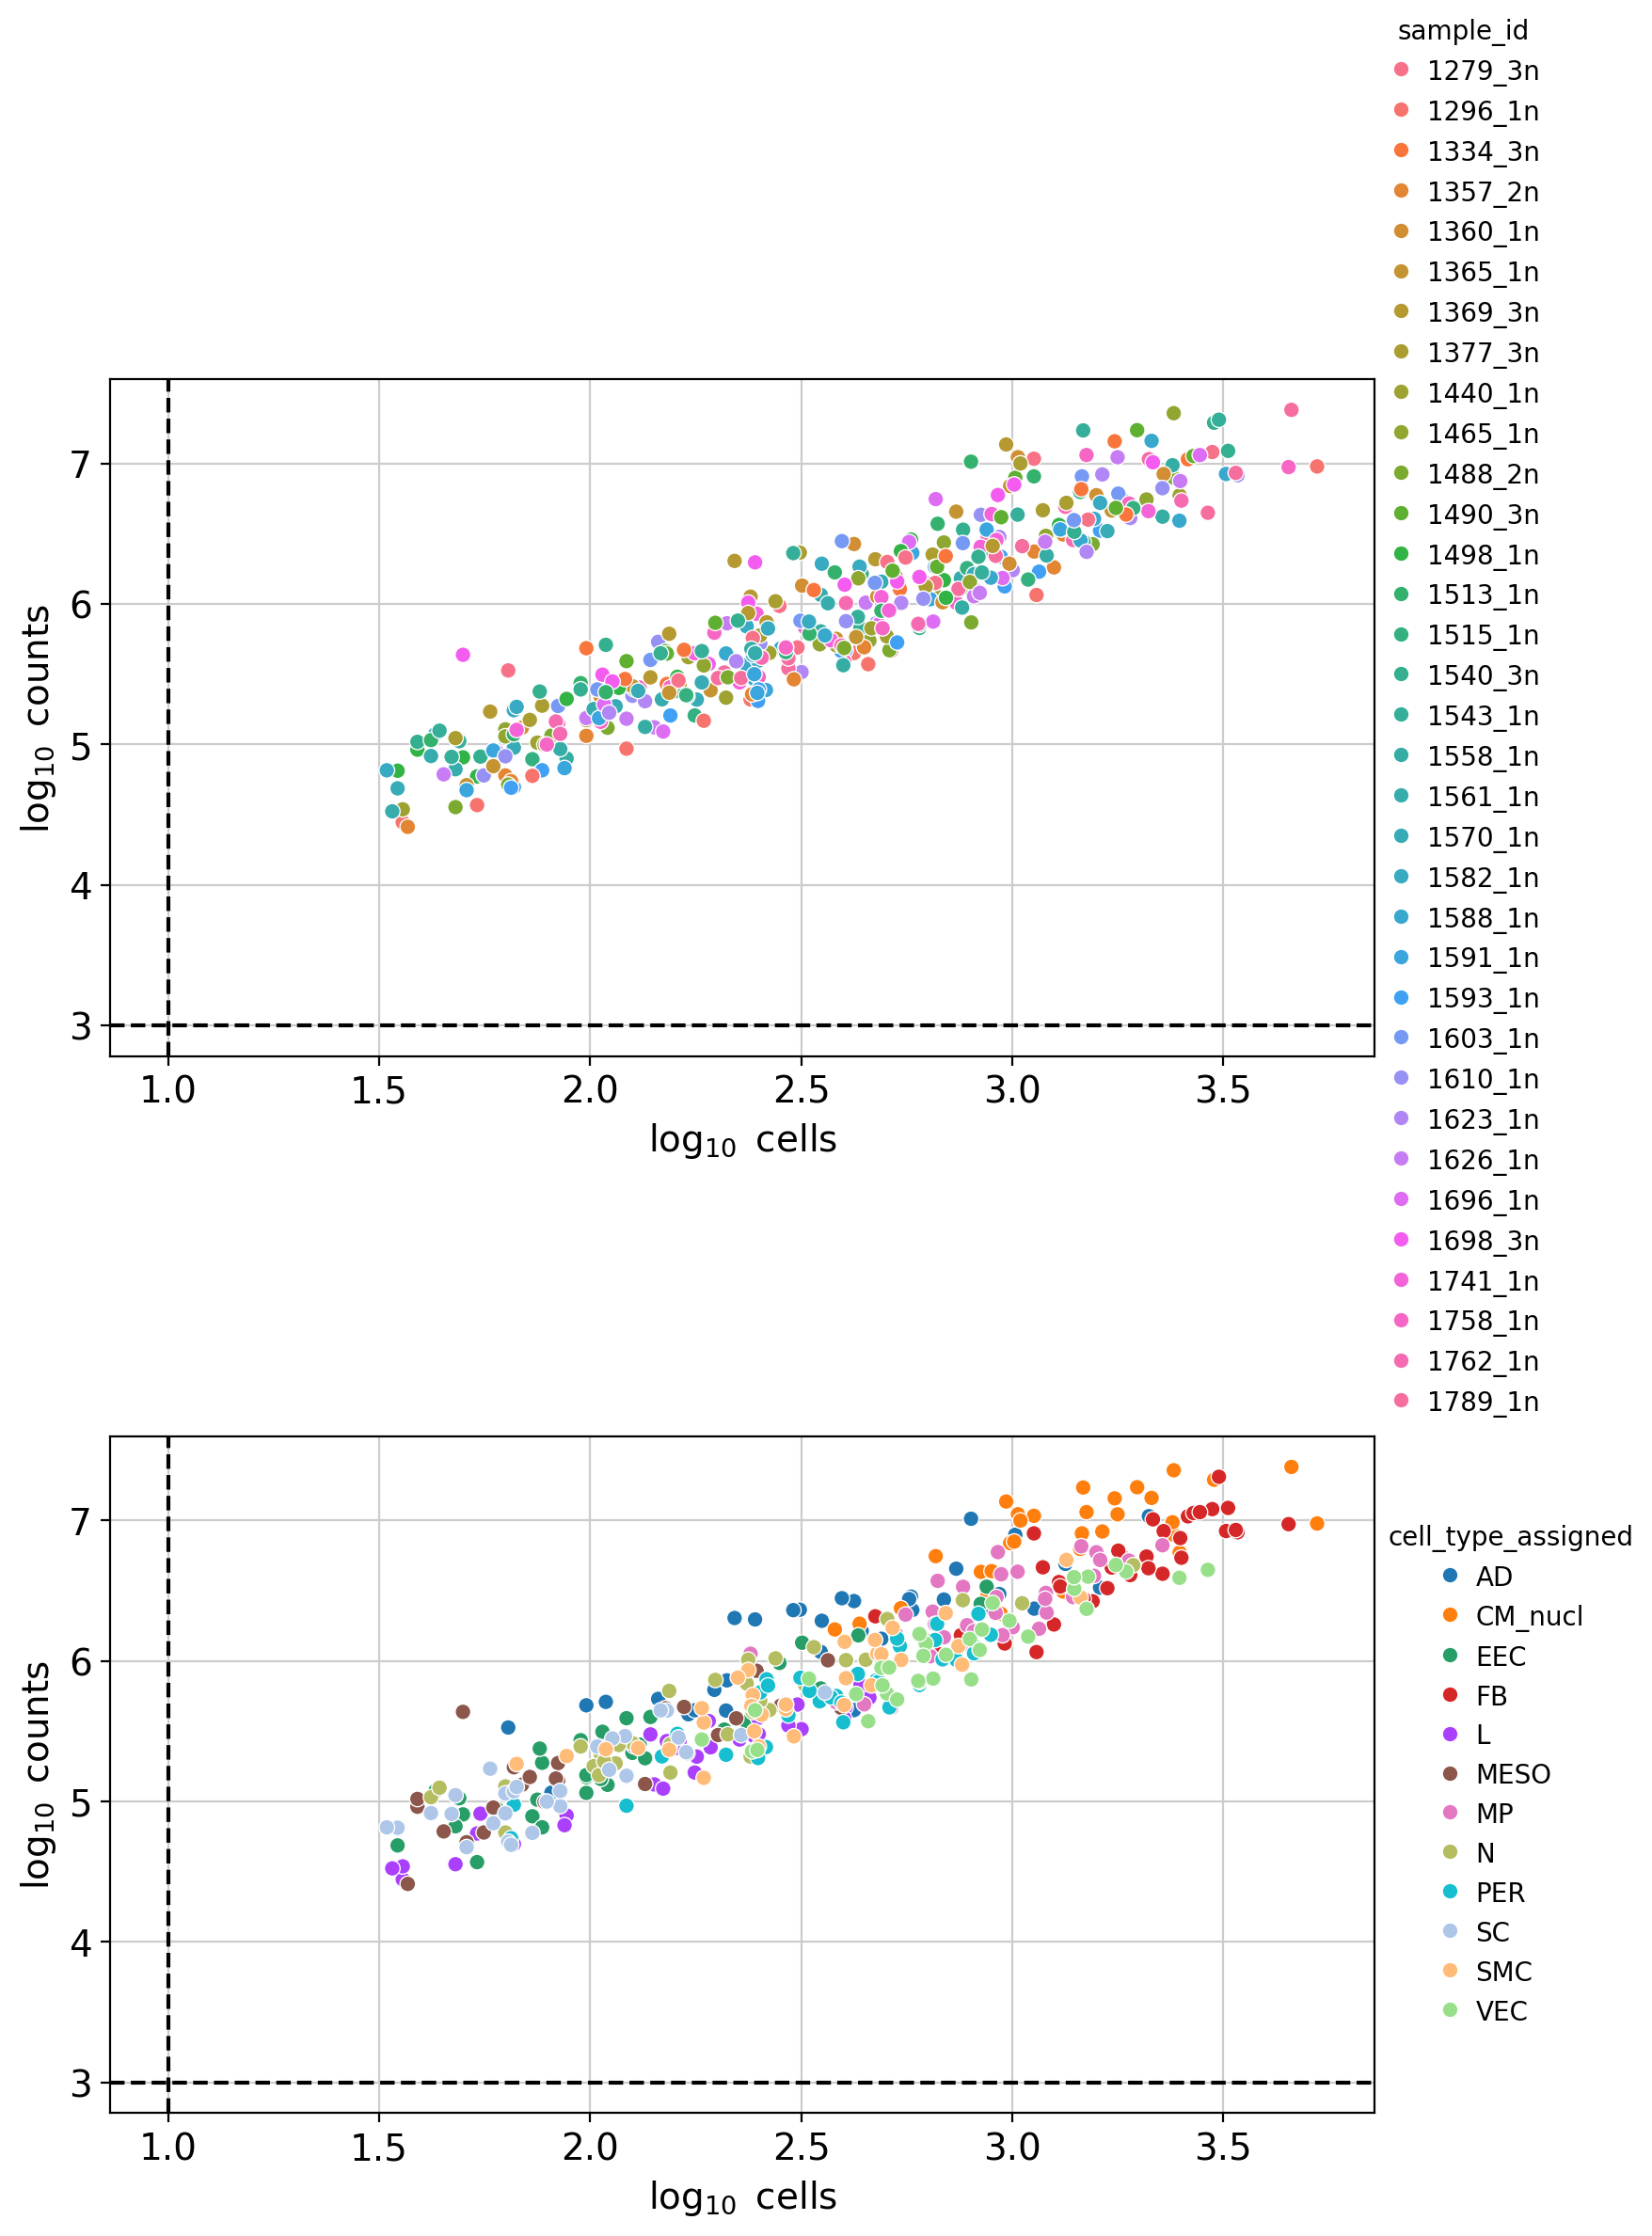

In [18]:
dc.pl.filter_samples(pdata, groupby=[sample_key, groupby], figsize=(9, 12))

In [29]:
%%capture

dea_results = {}
quiet = True

for cell_group in pdata.obs[groupby].unique():
    # Select cell profiles
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()
    
    # Build DESeq2 object
    # NOTE: this data is actually paired, so one could consider fitting the patient label as a confounder
    dds = DeseqDataSet(
        adata=ctdata,
        design_factors=condition_key,
        ref_level=[condition_key, 'control'], # set control as reference
        refit_cooks=True,
        quiet=quiet
    )
    
    # Compute LFCs
    dds.deseq2()
    # Contrast between stim and ctrl
    stat_res = DeseqStats(dds, contrast=[condition_key, 'case', 'control'], quiet=quiet)
    stat_res.quiet = quiet
    # Compute Wald test
    stat_res.summary()
    # Shrink LFCs
    stat_res.lfc_shrink(coeff='af_status[T.control]') # {condition_key}_cond_vs_ref
    
    dea_results[cell_group] = stat_res.results_df

/usr/people/EDVZ/farhadie/.local/lib/python3.10/site-packages/pydeseq2/utils.py:1088: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/usr/people/EDVZ/farhadie/.local/lib/python3.10/site-packages/pydeseq2/utils.py:1088: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/usr/people/EDVZ/farhadie/.local/lib/python3.10/site-packages/pydeseq2/utils.py:1088: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/usr/people/EDVZ/farhadie/.local/lib/python3.10/site-packages/pydeseq2/utils.py:1088: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/usr/people/EDVZ/farhadie/.local/lib/python3.10/site-packages/pydeseq2/utils.py:1088: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/usr/people/EDVZ/far

In [34]:
# concat results across cell types
dea_df = pd.concat(dea_results)
dea_df = dea_df.reset_index().rename(columns={'level_0': groupby,'level_1':'index'}).set_index('index')
dea_df

,cell_type_assigned,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
index,,,,,,,
KLKB1,AD,8.474088,-2.040348e-06,0.001380,0.657800,0.510667,0.999976
KCNJ6,AD,2.621609,-1.735719e-06,0.001359,0.786109,0.431803,0.999976
PCLO,AD,16.345811,1.865420e-06,0.001436,-0.451611,0.651549,0.999976
SLC10A1,AD,14.505616,-7.841269e-06,0.001312,2.288978,0.022081,0.999976
SLC39A13,AD,7.969916,-5.750537e-06,0.001411,1.204805,0.228279,0.999976
...,...,...,...,...,...,...,...
CBY3,VEC,0.524698,-9.907792e-07,0.001349,0.496155,0.619785,0.999869
ZNF131,VEC,184.746325,-2.932933e-05,0.001370,2.001703,0.045317,0.999869
RBP4,VEC,4.273461,-8.215907e-07,0.001333,0.473575,0.635803,0.999869


In [36]:
# concat results across cell types
dea_df = pd.concat(dea_results)
dea_df = dea_df.reset_index().rename(columns={'level_0': groupby,'level_1':'index'}).set_index('index')
dea_df

,cell_type_assigned,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
index,,,,,,,
KLKB1,AD,8.474088,2.054106e-06,0.001515,0.657799,0.510668,0.999974
KCNJ6,AD,2.621609,1.738316e-06,0.001544,0.786111,0.431802,0.999974
PCLO,AD,16.345811,-1.844562e-06,0.001449,-0.451607,0.651552,0.999974
SLC10A1,AD,14.505616,7.851845e-06,0.001623,2.288968,0.022081,0.999974
SLC39A13,AD,7.969916,5.747356e-06,0.001477,1.204805,0.228279,0.999974
...,...,...,...,...,...,...,...
CBY3,VEC,0.524698,9.036254e-07,0.001560,0.496117,0.619812,0.999869
ZNF131,VEC,184.746325,2.934155e-05,0.001530,2.001542,0.045334,0.999869
RBP4,VEC,4.273461,8.369400e-07,0.001584,0.473596,0.635788,0.999869


In [ ]:
# Ensure we always shrink and report as "case vs control", regardless of internal coding.

import pandas as pd

sample_key = 'sample_id'
groupby = 'cell_type_assigned'
condition_key = 'af_status'

dea_results = {}
quiet = True

# Optional: quick audit
print("Global levels in pdata.obs[af_status]:", 
      pd.Index(pdata.obs[condition_key].astype(str).unique()).tolist())

for cell_group in pdata.obs[groupby].unique():
    # Subset pseudobulk counts for this cell type
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()
    
    # Ensure condition is clean categorical and enforce desired order with 'control' as baseline
    if condition_key not in ctdata.obs:
        print(f"[{cell_group}] Missing '{condition_key}' in obs; skipping.")
        continue
    
    # Normalize strings and set categories present in this subset
    s = ctdata.obs[condition_key].astype(str).str.strip()
    cats_present = pd.Index(s.unique())
    # We want both case and control within the subset
    if not {"case", "control"}.issubset(set(cats_present)):
        print(f"[{cell_group}] Subset lacks both levels (has: {cats_present.tolist()}); skipping.")
        continue
    
    # Order: control (baseline) then case
    ctdata.obs[condition_key] = pd.Categorical(s, categories=["control", "case"], ordered=True)

    # Build DESeq2 object with 'control' as reference
    dds = DeseqDataSet(
        adata=ctdata,
        design_factors=condition_key,
        ref_level=[condition_key, "control"],
        refit_cooks=True,
        quiet=quiet
    )

    # Fit dispersion & LFCs
    dds.deseq2()

    # Stats object for case vs control
    stat_res = DeseqStats(dds, contrast=[condition_key, "case", "control"], quiet=quiet)
    stat_res.summary()

    # Determine the correct coefficient name dynamically
    # Typical patterns: "<condition_key>[T.case]" or "<condition_key>[T.control]"
    lfc_cols = list(stat_res.LFC.columns)
    coef_case = f"{condition_key}[T.case]"
    coef_ctrl = f"{condition_key}[T.control]"

    if coef_case in lfc_cols:
        coef_name = coef_case
        flip_sign = False
    elif coef_ctrl in lfc_cols:
        coef_name = coef_ctrl
        flip_sign = True  # will flip to report case vs control
        print(f"[{cell_group}] Found '{coef_ctrl}' -> will flip sign to report case vs control.")
    else:
        # Fallback: pick first matching and warn
        cand = [c for c in lfc_cols if c.startswith(f"{condition_key}[T.")]
        if not cand:
            print(f"[{cell_group}] No LFC column for '{condition_key}'. Available: {lfc_cols}; skipping.")
            continue
        coef_name = cand[0]
        flip_sign = coef_name.endswith("[T.control]")
        print(f"[{cell_group}] Using '{coef_name}'. Flip sign: {flip_sign}")

    # Shrink on the actual coefficient name
    stat_res.lfc_shrink(coeff=coef_name)

    # Optionally standardize the sign so results are always case vs control
    df = stat_res.results_df.copy()
    if flip_sign:
        for col in ["log2FoldChange", "lfc_shrink"]:
            if col in df.columns:
                df[col] = -df[col]

    # Store results
    dea_results[cell_group] = df

# Optionally: show which groups were analyzed
print("Finished groups:", list(dea_results.keys()))
